<a href="https://colab.research.google.com/github/vdslab/t-taiki0620/blob/main/visData/visdata%E3%81%AE%E6%8A%BD%E5%87%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ドライブマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


インポート

In [6]:
!pip install nltk

In [24]:
import os
import json
import csv
import pandas as pd
import numpy
import nltk
import re
import string
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

データ読み込み

In [8]:
with open('/content/drive/MyDrive/Colab Notebooks/pre-judgit/IEEE VIS papers 1990-2020 - Main dataset.csv', encoding='utf8')as f:
  df = pd.read_csv(f)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Conference                     3394 non-null   object 
 1   Year                           3394 non-null   int64  
 2   Title                          3394 non-null   object 
 3   DOI                            3394 non-null   object 
 4   Link                           3394 non-null   object 
 5   FirstPage                      3361 non-null   object 
 6   LastPage                       3351 non-null   object 
 7   PaperType                      3394 non-null   object 
 8   Abstract                       3321 non-null   object 
 9   AuthorNames-Deduped            3394 non-null   object 
 10  AuthorNames                    3390 non-null   object 
 11  AuthorAffiliation              3263 non-null   object 
 12  InternalReferences             2638 non-null   o

モデル作成

In [37]:
nltk.help.upenn_tagset() 

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [31]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
stem = PorterStemmer()
lem = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

In [35]:
trainings = []
for i in range(len(df)):
  try:
    trainings.append(TaggedDocument(lemmatize_sentence(df.loc[i]['Abstract']), [i]))
  except:
    pass

In [36]:
model = Doc2Vec(trainings, epochs=30, min_alpha=1e-4, sample=1e-3, min_count=4, window=15, vector_size=50)

モデル保存

In [38]:
model.save('/content/drive/MyDrive/Colab Notebooks/pre-judgit/VIS1990-2020.model')

モデル読み込み

In [39]:
model = Doc2Vec.load('/content/drive/MyDrive/Colab Notebooks/pre-judgit/VIS1990-2020.model')

デンドログラム作成

In [40]:
samples_list = []
df_exp = []
for i in range(len(trainings)):
  tmp = {}
  ind = df.index.get_loc(trainings[i].tags[0])
  if numpy.isnan(float('NaN')) != df.loc[ind]['AuthorKeywords']:
    tmp['Title'] = df.loc[ind]['Title']
    tmp['Abstract'] = df.loc[ind]['Abstract']
    tmp['Conference'] = df.loc[ind]['Conference']
    try:
      tmp['AuthorKeywords'] = df.loc[ind]['AuthorKeywords'].split()
    except:
      tmp['AuthorKeywords'] = []
    df_exp.append(model.docvecs[trainings[i].tags[0]])
    samples_list.append(tmp)
  if i%1000 == 0:
    print('doing')

doing
doing
doing
doing


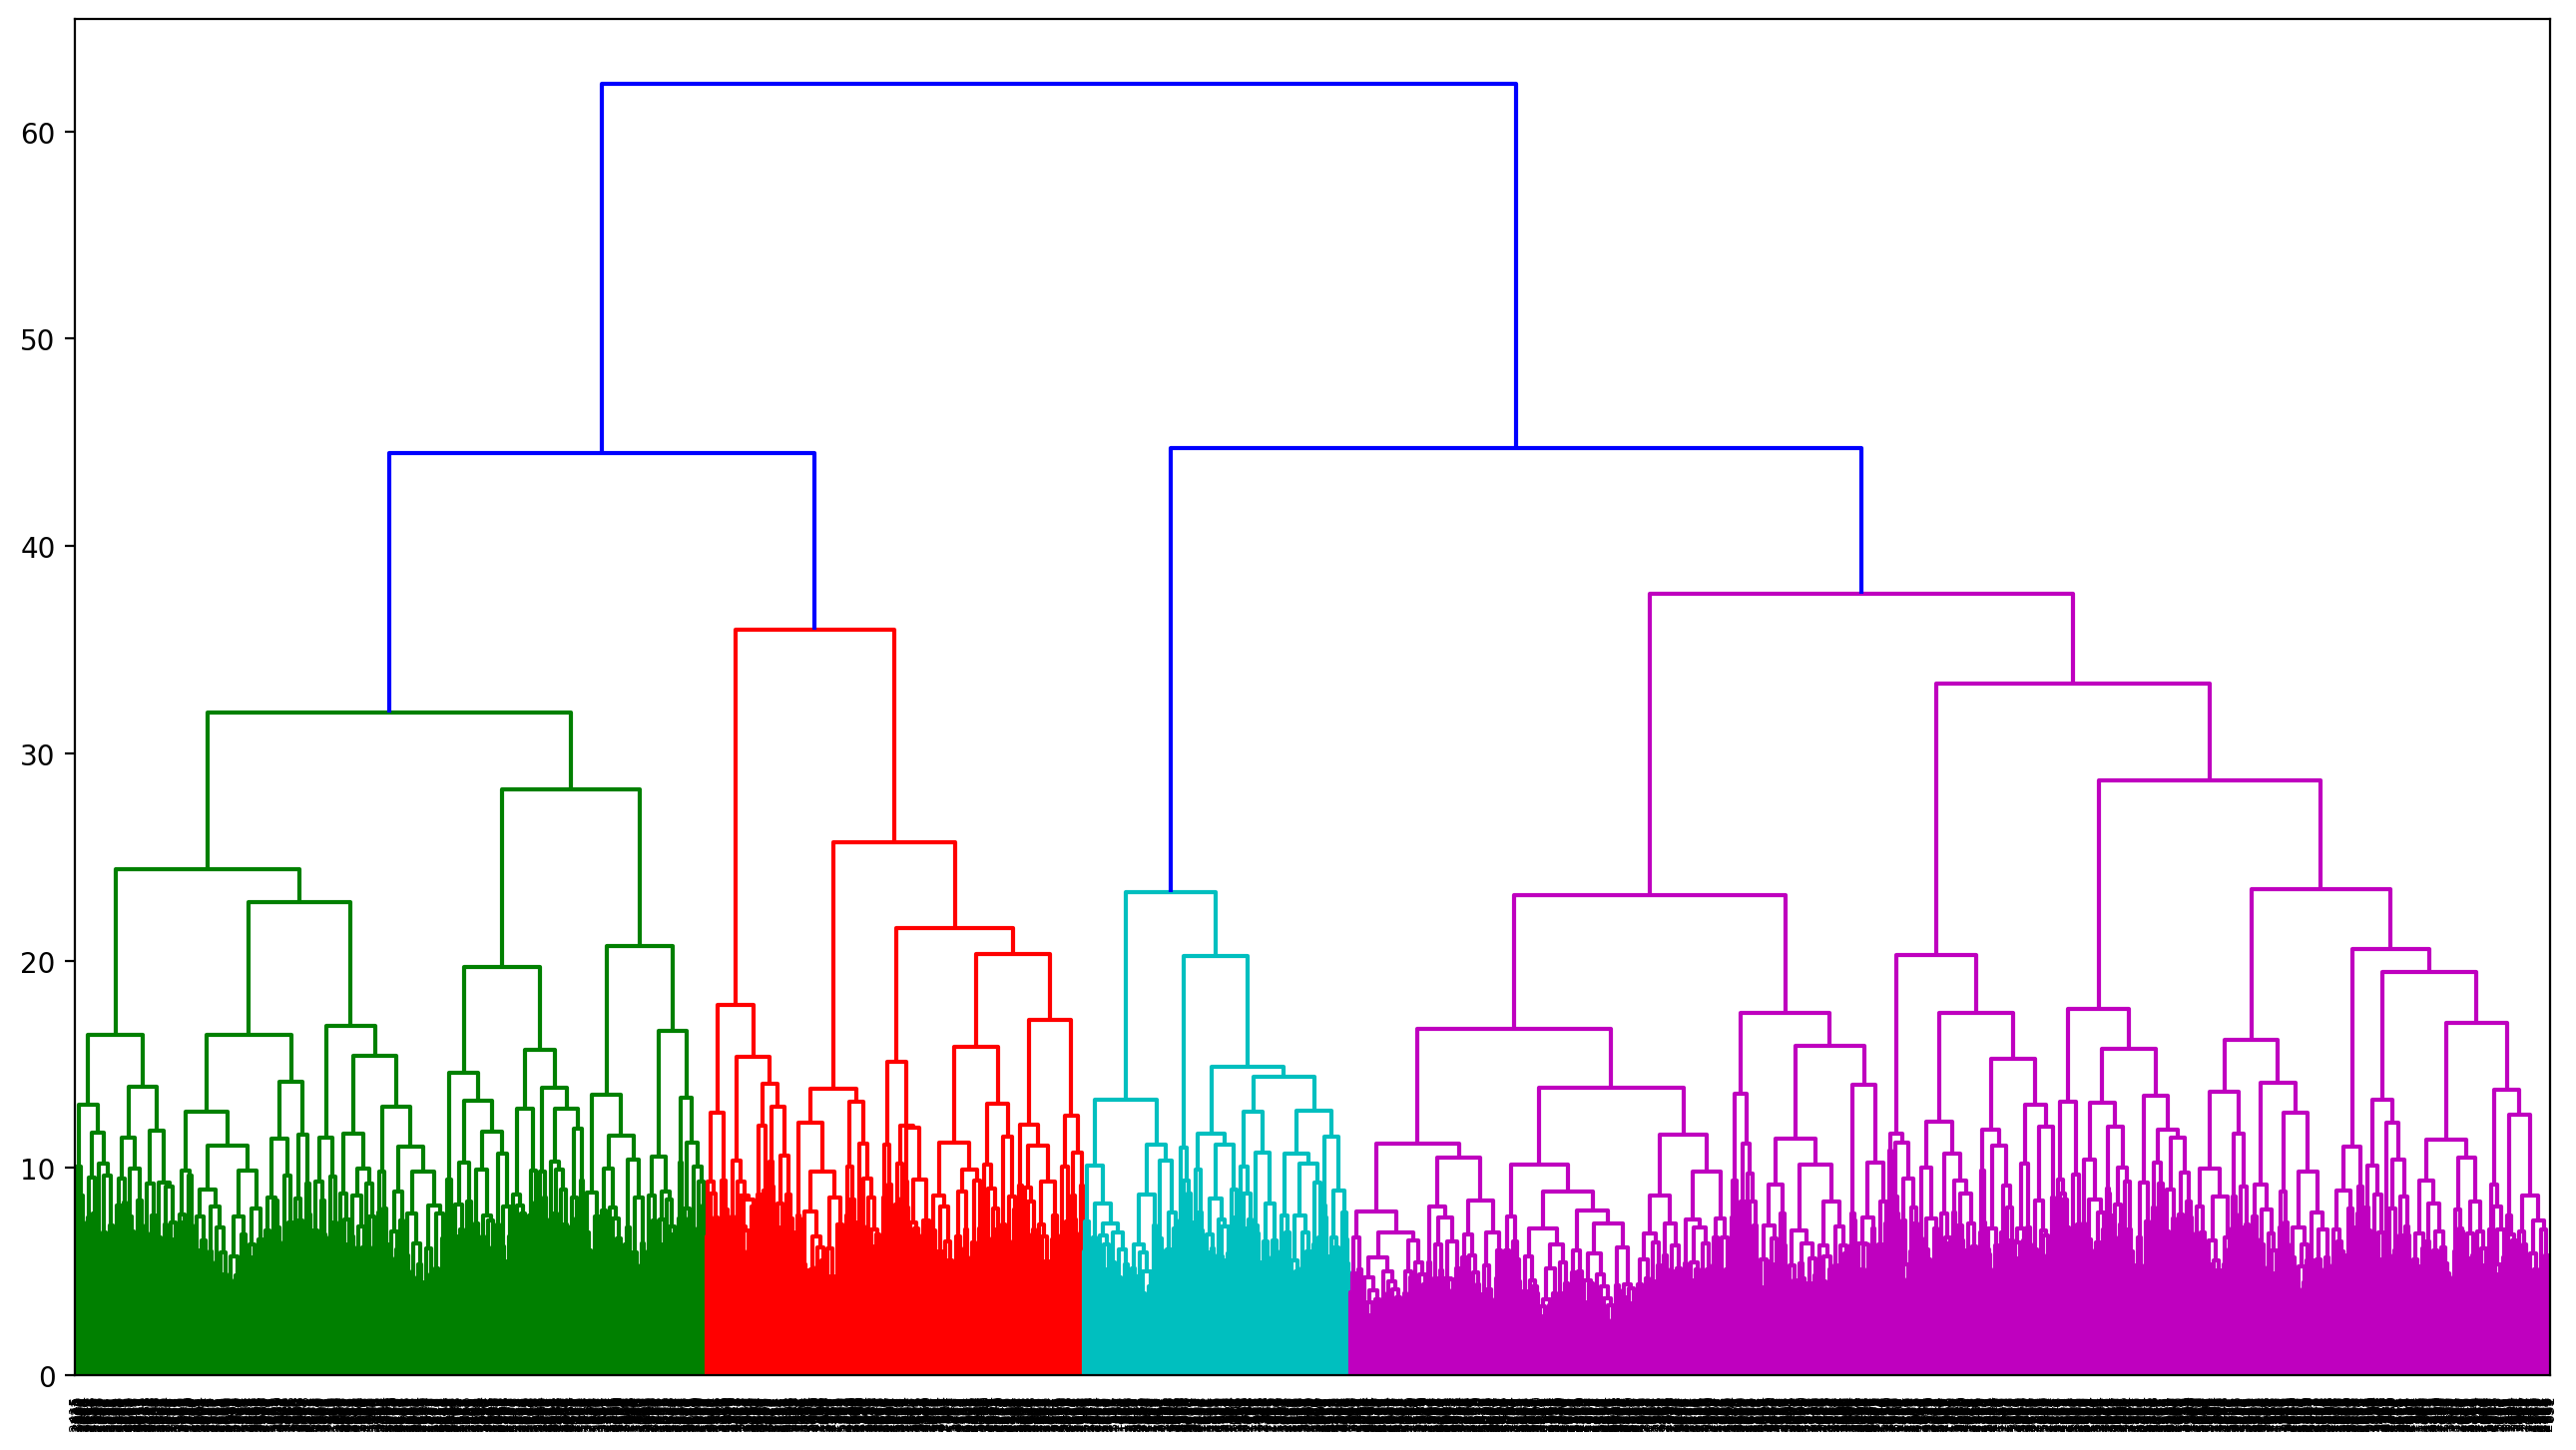

In [43]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
 
linkage_result = linkage(df_exp, method='ward', metric='euclidean')
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result, labels=df.index)
plt.show()

pke 抽出

In [44]:
!pip install git+https://github.com/boudinfl/pke.git
!python -m nltk.downloader stopwords
!python -m nltk.downloader universal_tagset
!python -m spacy download en_core_web_sm # download the english model

  Cloning https://github.com/boudinfl/pke.git to /tmp/pip-req-build-7q4l6xl9
  Running command git clone -q https://github.com/boudinfl/pke.git /tmp/pip-req-build-7q4l6xl9
     |████████████████████████████████| 235 kB 2.9 MB/s 
  Created wheel for pke: filename=pke-1.8.1-py3-none-any.whl size=8764193 sha256=35f6e164954d9485fbb2bb43db221b7a9c34a9ac5685fc020a81d70578e49289
  Stored in directory: /tmp/pip-ephem-wheel-cache-affn6y9w/wheels/fa/b3/09/612ee93bf3ee4164bcd5783e742942cdfc892a86039d3e0a33
Successfully built pke
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', b

In [45]:
import pke
import sys

sys.setrecursionlimit(10000)
def get_key_phrase(text, n = 5):
    """キーフレーズ処理

    Args:
        text ([type]): キーフレーズ対象の文字列
        n (int, optional): [description]. Defaults to 10.
        gc_collect (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    #MultipartiteRankなどのキーフレーズの手法については以下のサイトが参考になります
    #https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/part5.html
    extractor = pke.unsupervised.MultipartiteRank()
    extractor.load_document(input=text, language='en')
    extractor.candidate_selection()
    extractor.candidate_weighting(threshold=0.74, method='average', alpha=1.1)
    key_phrase = extractor.get_n_best(n)
    
    return  key_phrase
    
    
#spacyに設定されているstopwordを使う
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
df_pke = {}
df_enpty = []
for i in range(len(samples_list)):
  pke_test = {}
  for words in get_key_phrase(" ".join(lemmatize_sentence(samples_list[i]['Abstract']))):
    for word in words[0].split():
      if word in pke_test:
        pke_test[word] += words[1]
      else:
        pke_test[word] = words[1]

  df_pke[samples_list[i]['Title']] = pke_test
  if i % 50 == 0:
    print(df_pke[samples_list[i]['Title']])

{'novel': 0.09488063160964183, 'representation': 0.09488063160964183, 'data': 0.07849201989497023, 'transparent': 0.074804929569196, 'approach': 0.074804929569196, 'documents': 0.06494917394892041, 'visualization': 0.04707135144965376}
{'contour': 0.08145956589271817, 'spectrum': 0.08145956589271817, 'time': 0.07489755853385013, 'exact': 0.07489755853385013, 'quantification': 0.07489755853385013, 'user': 0.047020820366056405, 'interface': 0.047020820366056405, 'component': 0.047020820366056405, 'real': 0.04617679186148772, 'visualization': 0.0409937394831542}
{'information': 0.1320258897509431, 'visualization': 0.1320258897509431, 'query': 0.058657069898761176, 'device': 0.058657069898761176, 'exploration': 0.05741883812204639, 'environment': 0.05741883812204639, 'arbitrary': 0.041118428513798495, 'graphical': 0.041118428513798495, 'object': 0.041118428513798495, 'nee': 0.04014688186292522}
{'mesh': 0.0659470748459165, 'recent': 0.05890282908311396, 'year': 0.05890282908311396, 'sized'

In [66]:
for i in range(len(samples_list)):
  word_score = []
  tmp_list = sorted(df_pke[samples_list[i]['Title']].items(), key=lambda x: x[1], reverse=True)
  for data in tmp_list:
    word_score.append({"word" : data[0],
                      "score" : data[1]})
  samples_list[i]['MultipartiteRank'] = word_score

デンドログラムデータ出力

In [68]:
obj = []
for i in range(len(samples_list)):
  obj.append({"no":str(int(i)),
              "parent":"",
              "distance":0,
              "Title":samples_list[i]["Title"],
              "Abstract":samples_list[i]["Abstract"],
              "AuthorKeywords":samples_list[i]["AuthorKeywords"],
              "Conference":samples_list[i]["Conference"],
              "MultipartiteRank":samples_list[i]["MultipartiteRank"]
              })

for i in range(len(linkage_result)):
  obj.append({"no":str(len(linkage_result)+i+1),
              "parent":"",
              "distance":linkage_result[i][2],
              "Title":"",
              "Abstract":"",
              "AuthorKeywords":[],
              "Conference":"",
              "MultipartiteRank":[]
              })

for i in range(len(obj)):
  if i % 1000 == 0 :
    print("running", i)
  for j in range(len(linkage_result)):
    if int(obj[i]["no"]) == linkage_result[j][0] or int(obj[i]["no"]) == linkage_result[j][1]:
      obj[i]["parent"] = str(len(linkage_result)+j+1)

running 0
running 1000
running 2000
running 3000
running 4000
running 5000
running 6000


In [69]:
with open('/content/drive/MyDrive/Colab Notebooks/pre-judgit/test1123.json', 'w', encoding='utf8')as f:
  json.dump(obj, f, indent = 2, ensure_ascii=False)

key phraseの単語ベクトルの獲得

In [70]:
words_array = []
for i in range(len(samples_list)):
  if i%1000 == 0:
    print(i)
  try:
    for words in samples_list[i]['MultipartiteRank']:
      if words["word"] not in words_array:
        words_array.append(words["word"])
  except:
    print(i)

0
1000
2000
3000


In [71]:
vector_data = []
no_vectors_word = []
for word in words_array:
  try:
    tmp = {"word":word, "vector":list(float(x) for x in model.infer_vector(word))}
    vector_data.append(tmp)
  except:
    no_vectors_word.append(word)

In [72]:
print(len(vector_data), len(no_vectors_word))

4184 0


In [79]:
with open("/content/drive/MyDrive/Colab Notebooks/pre-judgit/word_vector1123.json", 'w', encoding="utf8")as f:
  json.dump(vector_data, f, indent=2, ensure_ascii=False)